In [1]:
from pathlib import Path

from sklearn.gaussian_process import (
    GaussianProcessRegressor,
    kernels
)
import polars as pl
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.pyplot import contourf

In [2]:
X = pl.DataFrame(
    data={
        "learning_rate": [
            0.0004791178, 
            0.0000500000, 
            0.0003714593, 
            0.0006785407, 
            0.0009046467,
            0.0010000000,
            0.0008114284,
            0.0005708822,
            0.0001453533,
            0.0002385716,
            0.00005, 
        ],
        "weight_decay": [
            0.000001000,
            0.004517577,
            0.006616557,
            0.003384443,
            0.001004619,
            0.005483423,
            0.008015234,
            0.010000000,
            0.008996381,
            0.001985766,
            0.009220960
        ]
    }
)

y = pl.DataFrame(
    data={
        "validation_cost": [
            0.4110,
            0.4289,
            0.3391,
            0.3331,
            0.4000,
            0.2995,
            0.3086,
            0.3227,
            0.3620,
            0.3887,
            0.3614 
        ]
    }
)
print(pl.concat(items=(X, y), how="horizontal"))

shape: (11, 3)
┌───────────────┬──────────────┬─────────────────┐
│ learning_rate ┆ weight_decay ┆ validation_cost │
│ ---           ┆ ---          ┆ ---             │
│ f64           ┆ f64          ┆ f64             │
╞═══════════════╪══════════════╪═════════════════╡
│ 0.000479      ┆ 0.000001     ┆ 0.411           │
│ 0.00005       ┆ 0.004518     ┆ 0.4289          │
│ 0.000371      ┆ 0.006617     ┆ 0.3391          │
│ 0.000679      ┆ 0.003384     ┆ 0.3331          │
│ 0.000905      ┆ 0.001005     ┆ 0.4             │
│ 0.001         ┆ 0.005483     ┆ 0.2995          │
│ 0.000811      ┆ 0.008015     ┆ 0.3086          │
│ 0.000571      ┆ 0.01         ┆ 0.3227          │
│ 0.000145      ┆ 0.008996     ┆ 0.362           │
│ 0.000239      ┆ 0.001986     ┆ 0.3887          │
│ 0.00005       ┆ 0.009221     ┆ 0.3614          │
└───────────────┴──────────────┴─────────────────┘


In [19]:
fig = px.scatter(
    data_frame=pl.concat(items=(X, y), how="horizontal").to_pandas(),
    x="learning_rate",
    y="weight_decay",
    color="validation_cost",
    size=5* np.ones(shape=y.select(pl.len()).item()),
    labels={
        "learning_rate": "Learning Rate",
        "weight_decay": "Weight Decay",
        "validation_cost": "Validation Cost"
    },
    title="Hyperparameter Experiment Results"
)
fig_dir = Path("../figures")
fig_dir.mkdir(parents=True, exist_ok=True)
fig_path = Path(fig_dir, "hyperparameter_experiment.png")
fig.write_image(fig_path, scale=5)

In [12]:
# https://stackoverflow.com/questions/24978052/interpolation-over-regular-grid-in-python
# https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-targets-py
rbf = kernels.RBF(length_scale=0.1, length_scale_bounds=(1e-9, 1e9))
gp = GaussianProcessRegressor(kernel=rbf, n_restarts_optimizer=10)
gp.fit(X=X, y=y)

GaussianProcessRegressor(kernel=RBF(length_scale=0.1), n_restarts_optimizer=10)

In [13]:
print(gp.kernel_)
print(gp.get_params())

RBF(length_scale=0.00347)
{'alpha': 1e-10, 'copy_X_train': True, 'kernel__length_scale': 0.1, 'kernel__length_scale_bounds': (1e-09, 1000000000.0), 'kernel': RBF(length_scale=0.1), 'n_restarts_optimizer': 10, 'n_targets': None, 'normalize_y': False, 'optimizer': 'fmin_l_bfgs_b', 'random_state': None}


In [14]:
num_points_per_axis = 1000
grid_x = pl.DataFrame(
    data={
        "learning_rate": np.linspace(
            start=X.select(pl.col("learning_rate").min()).item(),
            stop=X.select(pl.col("learning_rate").max()).item(),
            num=num_points_per_axis
        )
    }
)

grid_y = pl.DataFrame(
    data={
        "weight_decay": np.linspace(
            start=X.select(pl.col("weight_decay").min()).item(),
            stop=X.select(pl.col("weight_decay").max()).item(),
            num=num_points_per_axis
        )
    }
)

grid = grid_x.join(grid_y, how="cross")
print(grid)

shape: (1_000_000, 2)
┌───────────────┬──────────────┐
│ learning_rate ┆ weight_decay │
│ ---           ┆ ---          │
│ f64           ┆ f64          │
╞═══════════════╪══════════════╡
│ 0.00005       ┆ 0.000001     │
│ 0.00005       ┆ 0.000011     │
│ 0.00005       ┆ 0.000021     │
│ 0.00005       ┆ 0.000031     │
│ 0.00005       ┆ 0.000041     │
│ …             ┆ …            │
│ 0.001         ┆ 0.00996      │
│ 0.001         ┆ 0.00997      │
│ 0.001         ┆ 0.00998      │
│ 0.001         ┆ 0.00999      │
│ 0.001         ┆ 0.01         │
└───────────────┴──────────────┘


In [15]:
predicted_costs = gp.predict(
    X=grid
)

In [16]:
grid = (grid
    .with_columns([
        pl.lit(predicted_costs).alias("predicted_costs")
    ])       
)
print(grid.sort(by="predicted_costs"))

shape: (1_000_000, 3)
┌───────────────┬──────────────┬─────────────────┐
│ learning_rate ┆ weight_decay ┆ predicted_costs │
│ ---           ┆ ---          ┆ ---             │
│ f64           ┆ f64          ┆ f64             │
╞═══════════════╪══════════════╪═════════════════╡
│ 0.001         ┆ 0.007017     ┆ 0.281445        │
│ 0.001         ┆ 0.007027     ┆ 0.281447        │
│ 0.001         ┆ 0.007007     ┆ 0.281447        │
│ 0.001         ┆ 0.007037     ┆ 0.281451        │
│ 0.001         ┆ 0.006997     ┆ 0.281451        │
│ …             ┆ …            ┆ …               │
│ 0.000997      ┆ 0.000001     ┆ 0.452254        │
│ 0.001         ┆ 0.000011     ┆ 0.45227         │
│ 0.000998      ┆ 0.000001     ┆ 0.452336        │
│ 0.000999      ┆ 0.000001     ┆ 0.452418        │
│ 0.001         ┆ 0.000001     ┆ 0.4525          │
└───────────────┴──────────────┴─────────────────┘


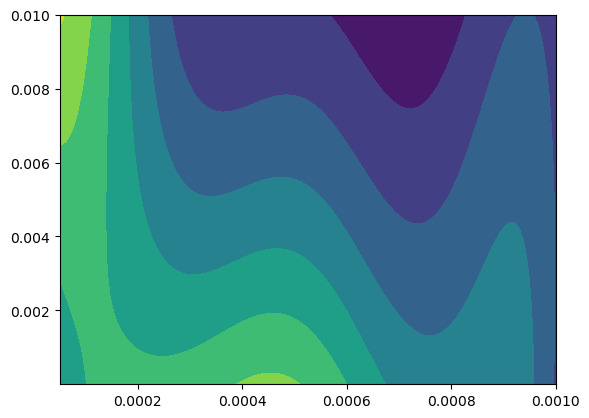

In [18]:
contourf(
    grid_x.to_series().to_numpy(),
    grid_y.to_series().to_numpy(),
    predicted_costs.reshape((grid_x.shape[0], grid_y.shape[0])),
    origin="lower"
)
fig_dir = Path("../figures")
fig_dir.mkdir(parents=True, exist_ok=True)
fig_path = Path(fig_dir, "hyperparameter_experiment_contour_plot.png")
plt.savefig(str(fig_path), dpi=900)

In [10]:
print(grid.sort(by="predicted_costs").filter(pl.col("learning_rate").is_between(0.0006, 0.0008)))

shape: (210_000, 3)
┌───────────────┬──────────────┬─────────────────┐
│ learning_rate ┆ weight_decay ┆ predicted_costs │
│ ---           ┆ ---          ┆ ---             │
│ f64           ┆ f64          ┆ f64             │
╞═══════════════╪══════════════╪═════════════════╡
│ 0.000601      ┆ 0.000001     ┆ 0.0             │
│ 0.000601      ┆ 0.000011     ┆ 0.0             │
│ 0.000601      ┆ 0.000021     ┆ 0.0             │
│ 0.000601      ┆ 0.000031     ┆ 0.0             │
│ 0.000601      ┆ 0.000041     ┆ 0.0             │
│ …             ┆ …            ┆ …               │
│ 0.000799      ┆ 0.00996      ┆ 0.0             │
│ 0.000799      ┆ 0.00997      ┆ 0.0             │
│ 0.000799      ┆ 0.00998      ┆ 0.0             │
│ 0.000799      ┆ 0.00999      ┆ 0.0             │
│ 0.000799      ┆ 0.01         ┆ 0.0             │
└───────────────┴──────────────┴─────────────────┘


In [11]:
print(grid.sort(by="predicted_costs").filter(pl.col("learning_rate").is_between(0.00090, 0.001)))

shape: (106_000, 3)
┌───────────────┬──────────────┬─────────────────┐
│ learning_rate ┆ weight_decay ┆ predicted_costs │
│ ---           ┆ ---          ┆ ---             │
│ f64           ┆ f64          ┆ f64             │
╞═══════════════╪══════════════╪═════════════════╡
│ 0.0009        ┆ 0.000001     ┆ 0.0             │
│ 0.0009        ┆ 0.000011     ┆ 0.0             │
│ 0.0009        ┆ 0.000021     ┆ 0.0             │
│ 0.0009        ┆ 0.000031     ┆ 0.0             │
│ 0.0009        ┆ 0.000041     ┆ 0.0             │
│ …             ┆ …            ┆ …               │
│ 0.001         ┆ 0.00996      ┆ 0.0             │
│ 0.001         ┆ 0.00997      ┆ 0.0             │
│ 0.001         ┆ 0.00998      ┆ 0.0             │
│ 0.001         ┆ 0.00999      ┆ 0.0             │
│ 0.001         ┆ 0.01         ┆ 0.0             │
└───────────────┴──────────────┴─────────────────┘
